# T014 · Binding site detection

Authors:

* Adapted from Abishek Laxmanan Ravi Shankar, 2019, internship at Volkamer lab
* Andrea Volkamer, 2020/21, [Volkamer lab, Charité](https://volkamerlab.org/)
* Dominique Sydow, 2020/21, [Volkamer lab, Charité](https://volkamerlab.org/)

## Aim of this talktorial

The binding site of a protein is the key to its function. In this talktorial, we introduce the concepts of computational binding site detection tools using DoGSiteScorer from the [protein.plus](https://proteins.plus/) web server, exemplified on an EGFR structure. 
Additionally, we compare the results to the pre-defined KLIFS binding site by calculating the percentage of residues in accordance between the two sets.

### Contents in *Theory*

* Protein binding sites
* Binding site detection
    * Methods overview
    * DoGSiteScorer
* Comparison to KLIFS pocket

### Contents in *Practical*

* Binding site detection using DoGSiteScorer
    * Job submission of structure of interest
    * Get DoGSiteScorer pocket metadata
    * Pick the most suitable pocket
    * Get best binding site file content
    * Investigate detected pocket
* Comparison between DoGSiteScorer and KLIFS pocket
    * Get DoGSiteScorer pocket residues
    * Get KLIFS pocket residues
    * Overlap of pocket residues

### References
* Prediction, Analysis, and Comparison of Active Sites [Volkamer <i>et al.</i>, (<b>2018</b>)](https://doi.org/10.1002/9783527806539.ch6g), book chapter in Applied Chemoinformatics: Achievements and Future Opportunities, Wiley
* DoGSiteScorer, [Volkamer <i>et al.</i>, <i>J.Chem.Inf.Model</i>, (<b>2012</b>), 52(2):360-372](https://pubmed.ncbi.nlm.nih.gov/22148551/)
* [ProteinsPlus](https://proteins.plus/): a web portal for structure analysis of macromolecules. [Fährrolfes <i>et al.</i>, <i>NAR</i>, (<b>2017</b>), 3;45(W1)](https://pubmed.ncbi.nlm.nih.gov/28472372/)
* [KLIFS](https://klifs.net/): a structural kinase-ligand interaction database, [Kanev <i>et al.</i>, <i>NAR</i>, (<b>2021</b>), 49(D1):D562-D569](https://academic.oup.com/nar/article/49/D1/D562/5934416) 

## Theory

### Protein binding sites

Most biological processes are guided through (non-)reversible binding of molecules. Given a therapeutic target associated to a specific disease, knowing its binding site(s), i.e. the key to the proteins function, is of utmost importance for designing new drugs.

Depending on the given data, e.g., no protein-ligand complex structure (x-ray) is available or one is interested in allosteric sites, binding site detection algorithms come into play. Binding sites, or in the case of enzymes rather called active sites, are cavities in 3-dimensional space, mostly on the surface of a protein structure, that serve as binding (docking) regions for ligands, peptides, or proteins. To interact with each other, the two binding partners need to be complementary concerning shape and physico-chemical properties (*key and look* principle).

![Binding site example](images/3w32_SP_0_0_scale025.png)

*Figure 1:* Example of a detected binding site for EGFR kinase (PDB: [3w32](https://www.rcsb.org/structure/3W32)) using DoGSiteScorer from [proteins.plus](https://proteins.plus). Protein shown as blue cartoon, ligand as sticks (carbons in gray) and binding site as violet cloud (largest subpocket SP_0_0 shown).


### Binding site detection

#### Methods overview

If ligand information is available, i.e., a protein-ligand complex, the protein residues surrounding the ligand can simply be defined as pocket (e.g. using all protein residues within a predefined radius of the ligand atoms such as 6 Å). If the ligand is absent, prediction tools can be used for *in silico* pocket detection. These methods can be grouped on the one hand in geometry- and energy-based methods as well as on the other hand in grid-based and grid-free approaches, as outlined in Figure 2. Note that in recent years, more and more machine or deep learning based methods have been developed (see e.g. [DeepSite](https://doi.org/10.1093/bioinformatics/btx350) by Jiménez *et al.*, Bioinformatics, 2017, 33(19), 3036–3042).

![Binding site detection methods](images/Figure2_DetectionMethods_scale05.png)

*Figure 2*: Binding site detection methods can be grouped into geometry-based and energy-based approaches as well as grid-based and grid-free approaches. Figure taken from Prediction, Analysis, and Comparison of Active Sites, [Volkamer <i>et al.</i>, (<b>2018</b>)](https://doi.org/10.1002/9783527806539.ch6g), Applied Chemoinformatics: Achievements and Future Opportunities, Wiley.

**Geometry-based approaches** analyze the shape of a molecular surface to locate cavities and incorporate the 3D spatial arrangement of the atoms on the protein surface. **Energy-based approaches** record interactions of probes or molecular fragments with the protein, thus, favorable energetic responses are assigned to pockets. Both strategies can be performed on a Cartesian **grid-based** representation of the protein (i.e. checking the environment per grid point) or without (i.e. **grid-free**). 

In the following, an example for each of the four categories will be shortly introduced:

* *Geometric, grid-based approach*: In [**LIGSITE**](https://doi.org/10.1016/s1093-3263(98)00002-3) (Hendlich, *et al.*, J Mol Graph Model., 1997, 15(6):359-63, 389), a Cartesian grid (e.g. 1Å grid spacing) is spanned over the protein of interest. Each grid point is then scanned in seven direction (along the x, y and z axes as well as the four cubic diagonals) and the number of Protein-Solvent-Protein (PSP) events per point is stored (# rays restricted on both side by the protein). Finally, grid points that are buried (= have a high PSP value) are clustered to pockets.
* *Geometric, grid-free approach*: In [**SURFNET**](https://doi.org/10.1016/0263-7855(95)00073-9) (Laskowski, J Mol Graph., 1995, 13(5):323-30, 307-8), spheres are placed midway between all pairs of atoms on the protein surface directly. In case a probe clashes with any nearby atom, its radius is reduced until no overlap occurs. The resulting probes define the cavities.
* *Energy, grid-based approach*: In [**DrugSite**](https://doi.org/10.11234/GI1990.15.2_31) (An, *et al.*, Genome Informatics, 2004, 15(2): 31–41), the protein is embedded in a Cartesian grid and carbon probes are placed on each grid point. Then, van der Waals energies between the probe and the protein environment within 8 Å distance are calculated. Grid points with unfavorable energies, i.e., above an energy cut-off based on the mean energy and standard deviation over the whole grid, are discarded. Finally, grid points fulfilling this cut-off are merged to pockets.
* *Energy, grid-free approach*:  In **docking**-based methods, fragments (or small molecules) are docked against the protein of interest (placed and scored, for more info on docking see talktorial T015). Pockets are then assigned based on the quantity of fragments that bind to a specific area.

#### DoGSiteScorer

In this talktorial, we will use the DoGSiteScorer functionality, available within [protein.plus](https://proteins.plus/), to detect and score the pockets of a protein of interest. Thus, the algorithm will be explained in a bit more detail (see Figure 3 for a visual explanation).

* *Pocket detection*: DoGSiteScorer incorporates a **geometric** and **grid-based** algorithm to detect pockets. The protein is embedded in a Cartesian grid, and each grid point is labeled as either 0 (free) or 1 (occupied), depending on if it lies within any protein atom's van der Waals radius. Then, an edge-detection algorithm from image processing, a **Difference of Gaussian filter** (thus the name DoGSite) is invoked to identify protrusion on the protein surface (i.e. the positions on a protein surface where the location of a sphere-like object is favorable). Based on specific cut-off criteria, grid points with the highest intensity are selected and first clustered to subpockets, then merged to pockets. 
* *Descriptor calculation*: Based on the grid representation of the respective pocket as well as the surrounding protein atoms, properties describing the pocket are derived. These include properties such as volume, surface, or depth of the pocket (calculated directly from the properties of the individual grid points) as well as hyprophobicity, number of available hydrogen bond donors/acceptors or amino acid count (derived from the neighboring protein residues).  
* *Druggability estimates*: Additionally, the tool has an in-built druggability predictor. [Druggability](https://en.wikipedia.org/wiki/Druggability) can be defined as the ability of a (disease-associated) target to bind - and potentially be modulated by - low molecular weight compounds (sometimes also referred to as ligandability). In DoGSiteScorer, druggablity is predicted using a support vector machine (SVM) model, trained and tested on the freely available (non-redundant) druggability data set (NR) DD. The DD consists of 1069 targets and each target was assigned to one of the three classes: druggable, difficult, or undruggable. 

    For more detail on DoGSiteScorer's druggability model, see [Volkamer <i>et al.</i>, J. Chem. Inf. Model., 2012, 52, 2, 360–372](https://pubs.acs.org/doi/10.1021/ci200454v). For more info on the *druggability* concept itself refer to e.g. Hopkins and Groom, [The druggable genome](https://www.nature.com/articles/nrd892). Nat Rev Drug Discov 1, 727–730 (2002).

![DoGSiteScorer methodology](images/3w32_DoGSite_Overview_scale05.png)

*Figure 3*: Schematic representation of the individual steps within DoGSiteScorer: A. Pocket detection, B. descriptor calculation and C. druggability estimation. Figure newly composed based on [Volkamer <i>et al.</i>, J. Chem. Inf. Model., **2012**, 52(2), 360–372](https://pubs.acs.org/doi/10.1021/ci200454v) and [Volkamer <i>et al.</i>, J. Chem. Inf. Model., **2010**, 50(11), 2041–2052](https://pubs.acs.org/doi/10.1021/ci100241y).


### Comparison to KLIFS pocket

Once we obtain the binding site of interest from DoGSiteScorer, we can compare the results with any other method in order to validate it. Here, we compare it with the KLIFS binding pocket definition for our target kinase structure using the KLIFS API (see **Talktorial T012** for more detail).

**KLIFS pocket definition** in a nutshell:
The [KLIFS](https://klifs.net/) (Kinase-Ligand Interaction Fingerprints and Structures) database is a structural repository of information on over 3600 human and mouse kinase structures. The curated KLIFS data allows systematic analyses of all kinase structures and binding sites, bound ligands and protein-ligand interactions. KLIFS comes with a nomenclature of typical structural motifs within kinases (such as DFG-in/out, hinge region, ...) and maps the binding site of all known kinases to 85 residues, defined via an elaborated multiple sequence alignment. It is possible to compare the interaction patterns of kinase-inhibitors to each other to, for example, identify crucial interactions determining kinase-inhibitor selectivity. 

In this talktorial, we will query the KLIFS API to return the binding pocket of a specific protein kinase structure of interest for further analysis.

## Practical

In this practical part, we will introduce how to query the [proteins.plus](https://proteins.plus) server for binding site detection using DoGSiteScorer for our protein of interest.

Import all necessary libraries.

In [1]:
import io
from pathlib import Path
import time
import gzip

import requests
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
import pandas as pd
from biopandas.pdb import PandasPdb
import nglview

from opencadd.databases.klifs import setup_remote

pd.set_option("display.max_columns", 50)

Add globals to this talktorial's path (`HERE`) and its data folder (`DATA`).

In [2]:
HERE = Path(_dh[-1])
DATA = HERE / "data"
DATATMP = DATA / "_tmp"
DATATMP.mkdir(parents=True, exist_ok=True)

### Binding site detection using DoGSiteScorer
We first define a function to query the server for a protein of interest.
Infos on the REST API can be found [here](https://proteins.plus/help/dogsite_rest).

In [3]:
def submit_dogsitescorer_job_with_pdbid(pdb_code, chain_id, ligand=""):
    """
    Submit PDB ID to DoGSiteScorer webserver using their API and get back URL for job location.

    Parameters
    ----------
    pdb_code : str
        4-letter valid PDB ID, e.g. '3w32'.
    chain_id : str
        Chain ID, e.g. 'A'.
    ligand : str
        Name of ligand bound to PDB structure with pdb_id, e.g. 'W32_A_1101'.
        Currently, the ligand name must be checked manually on the DoGSiteScorer website.

    Returns
    -------
    str
        Job location URL for submitted query.

    References
    ----------
    Function is adapted from: https://github.com/volkamerlab/TeachOpenCADD/pull/3 (@jaimergp)
    """

    # Submit job to proteins.plus
    # For details on parameters see: https://proteins.plus/help/dogsite_rest
    r = requests.post(
        "https://proteins.plus/api/dogsite_rest",
        json={
            "dogsite": {
                "pdbCode": pdb_code,  # PDB code of protein
                "analysisDetail": "1",  # 1 = include subpockets in results
                "bindingSitePredictionGranularity": "1",  # 1 = include drugablity scores
                "ligand": ligand,  # if name is specified, ligand coverage is calculated
                "chain": chain_id,  # if chain is specified, calculation is only performed on this chain
            }
        },
        headers={"Content-type": "application/json", "Accept": "application/json"},
    )

    r.raise_for_status()

    return r.json()["location"]

#### Job submission for structure of interest

Define the protein of interest. As an example, we chose an EGFR kinase structure, more details can be found in the respective PDB entry: [3w32](https://www.rcsb.org/structure/3W32).

In [4]:
pdb_id = "3w32"
chain_id = "A"
# Ligand id manually looked-up from DoGSiteScorer within proteins.plus
# Note that it is generally composed of [pdb_lig_id]_[chain_id]_[pdb_residue_id]
ligand_id = "W32_A_1101"

Submit the query and identify the job location (URL) on the web server for further investigation.

In [5]:
job_location = submit_dogsitescorer_job_with_pdbid(pdb_id, chain_id, ligand_id)
job_location

'https://proteins.plus/api/dogsite_rest/AY5cZuXNWepL9xiJJNjjiaqL'

#### Get DoGSiteScorer pocket metadata
We now define a function that collects all data returned by the server and stores them in a pandas `DataFrame`.

In [6]:
def get_dogsitescorer_metadata(job_location, attempts=30):
    """
    Get results from a DoGSiteScorer query, i.e., the binding sites which are found over the protein surface,
    in the form of a table with the details about all detected pockets.

    Parameters
    ----------
    job_location : str
        Consists of the location of a finished DoGSiteScorer job on the proteins.plus web server.
    attempts : int
        The time waiting for the feedback from DoGSiteScorer service.

    Returns
    -------
    pandas.DataFrame
        Table with metadata on detected binding sites.
    """

    print(f"Querying for job at URL {job_location}...", end="")

    while attempts:
        # Get job results
        result = requests.get(job_location)
        result.raise_for_status()
        # Get URL of result table file
        response = result.json()
        if "result_table" in response:
            result_file = response["result_table"]
            break
        attempts -= 1
        print(".", end="")
        time.sleep(10)
    # Get result table (as string)
    result_table = requests.get(result_file).text
    # Load the table (csv format using "\t" as separator) with pandas DataFrame
    # We cannot load the table from a string directly but from a file
    # Use io.StringIO to wrap this string as file-like object as needed for read_csv method
    # See more: https://docs.python.org/3/library/io.html#io.StringIO
    result_table_df = pd.read_csv(io.StringIO(result_table), sep="\t").set_index("name")

    return result_table_df

All detected pockets from DoGSiteScorer web server are retrieved and a dataframe is returned containing all pocket descriptor information.

In [7]:
metadata = get_dogsitescorer_metadata(job_location)
metadata.head()

Querying for job at URL https://proteins.plus/api/dogsite_rest/AY5cZuXNWepL9xiJJNjjiaqL...

,lig_cov,poc_cov,lig_name,volume,enclosure,surface,depth,surf/vol,lid/hull,ellVol,ell c/a,ell b/a,siteAtms,accept,donor,hydrophobic_interactions,hydrophobicity,metal,Cs,Ns,Os,Ss,Xs,negAA,posAA,polarAA,apolarAA,ALA,ARG,ASN,ASP,CYS,GLN,GLU,GLY,HIS,ILE,LEU,LYS,MET,PHE,PRO,SER,THR,TRP,TYR,VAL,simpleScore,drugScore
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
P_0,85.48,31.22,W32_A_1101,1422.66,0.10,1673.75,19.26,1.176493,-,-,0.13,0.67,288,86,40,71,0.36,0,198,45,41,4,0,0.10,0.13,0.24,0.53,4,5,2,5,2,2,1,5,0,3,12,3,2,3,3,1,2,1,1,5,0.63,0.810023
P_0_0,85.48,73.90,W32_A_1101,599.23,0.06,540.06,17.51,0.901257,-,-,0.14,0.22,131,35,13,25,0.34,0,95,16,17,3,0,0.03,0.10,0.28,0.59,1,2,1,1,2,1,0,2,0,2,7,1,2,2,1,0,2,0,0,2,0.59,0.620201
P_0_1,3.23,0.44,W32_A_1101,201.73,0.08,381.07,11.36,1.889010,-,-,0.17,0.25,51,17,9,10,0.28,0,36,6,7,2,0,0.08,0.17,0.25,0.50,1,1,0,1,1,1,0,0,0,0,3,1,1,0,0,0,1,0,0,1,0.17,0.174816
P_0_2,0.00,0.00,W32_A_1101,185.60,0.17,282.00,9.35,1.519397,-,-,0.45,0.55,48,17,8,12,0.32,0,31,8,8,1,0,0.17,0.25,0.08,0.50,0,2,0,1,0,0,1,1,0,0,2,1,1,1,0,0,0,0,0,2,0.13,0.195695
P_0_3,6.45,0.29,W32_A_1101,175.30,0.15,297.42,9.29,1.696634,-,-,0.23,0.37,48,16,8,14,0.37,0,32,8,8,0,0,0.14,0.14,0.36,0.36,1,1,1,2,0,0,0,3,0,0,1,1,0,1,1,1,0,0,0,1,0.13,0.168845


**Note**: We selected to have pockets and subpockets returned from the algorithm, e.g. pocket ``P_0`` contains subpockets ``P_0_0`` to ``P_0_5``. Depending on your research question you might prefer to work with the pockets - mostly if you are more interested in the general location (e.g. for docking) - or the subpockets, which give a more granular description.

#### Pick the most suitable pocket
The pockets are initially sorted by the volume of the respective pocket.
We want to have a deeper look at the pocket that contains the ligand (see ligand coverage column ``lig_cov``) and which is covered by the ligand the most (pocket coverage ``poc_cov``). 

For clarity, we drop a few columns first from the dataframe.

In [8]:
metadata = metadata[
    [
        "lig_cov",
        "poc_cov",
        "lig_name",
        "volume",
        "enclosure",
        "surface",
        "depth",
        "surf/vol",
        "accept",
        "donor",
        "hydrophobic_interactions",
        "hydrophobicity",
        "metal",
        "simpleScore",
        "drugScore",
    ]
]

Sort the obtained binding site by your column of interest.

In [9]:
metadata.sort_values(by=["lig_cov", "poc_cov"], ascending=False).head()
# NBVAL_CHECK_OUTPUT

,lig_cov,poc_cov,lig_name,volume,enclosure,surface,depth,surf/vol,accept,donor,hydrophobic_interactions,hydrophobicity,metal,simpleScore,drugScore
name,,,,,,,,,,,,,,,
P_0_0,85.48,73.90,W32_A_1101,599.23,0.06,540.06,17.51,0.901257,35,13,25,0.34,0,0.59,0.620201
P_0,85.48,31.22,W32_A_1101,1422.66,0.10,1673.75,19.26,1.176493,86,40,71,0.36,0,0.63,0.810023
P_0_3,6.45,0.29,W32_A_1101,175.30,0.15,297.42,9.29,1.696634,16,8,14,0.37,0,0.13,0.168845
P_0_1,3.23,0.44,W32_A_1101,201.73,0.08,381.07,11.36,1.889010,17,9,10,0.28,0,0.17,0.174816
P_0_2,0.00,0.00,W32_A_1101,185.60,0.17,282.00,9.35,1.519397,17,8,12,0.32,0,0.13,0.195695


**Note**: We decided here to select the pocket with the best ligand and pocket coverage to have a precise description of the pocket for our comparison later. In other drug design scenarios, you might want to simply sort by ``drugScore`` (``metadata.sort_values(by='drugScore', ascending=False)``) or other values, such as ``volume`` or ``simpleScore``.

We define a function that returns the ID (variable is called ``best_pocket_id``) of the pocket that fullfills our sorting criterion.

In [10]:
def select_best_pocket(metadata, sorted_by="drugScore"):
    """
    This function uses the defined sorting parameter to identify
    the best pocket among the obtained pockets.

    Parameters
    ----------
    metadata : pd.DataFrame
        Pockets retrieved from the DoGSiteScorer website

    by : str
        Method name(s) to sort table by (default is to sort by drugScore).

    Returns
    -------
    str
        Best binding site name.
    """

    by_methods = ["drugScore", "volume", "simpleScore", "lig_cov", "poc_cov"]

    # Sort by the selected method
    if all(elem in by_methods for elem in sorted_by):
        sorted_pocket = metadata.sort_values(sorted_by, ascending=False)
    else:
        raise ValueError(f'Selection method not in list: {", ".join(by_methods)}')

    # Get name of best pocket
    best_pocket_name = sorted_pocket.iloc[0, :].name

    return best_pocket_name

We now programatically access the name of the best pocket based on the selected sorting.

In [11]:
best_pocket_id = select_best_pocket(metadata, ["lig_cov", "poc_cov"])
best_pocket_id
# NBVAL_CHECK_OUTPUT

'P_0_0'

#### Get binding site file content

We define two helper functions to first get the URL for all pocket pdb or ccp4 files, respectively. Then, we only process the files further for our pocket of interest.

Note that DoGSiteScorer returns two structural (3D) file formats per pocket:

* *pdb*: These files contain all atoms/residues surrounding the pocket.
    * Accessed via ``residues``
    * Naming scheme, e.g. 3w32_P_0_0``_res.pdb``
* *ccp4*: These files contain the grid points composing the pocket, also considered the *volume* of the pocket.
    * Accessed via ``pockets``
    * Naming scheme, e.g. 3w32_P_0_0``_gpsAll.ccp4.gz``

In [12]:
def get_url_for_pockets(job_location, file_type="pdb"):
    """
    Get all pocket file locations for a finished DoGSiteScorer job
    for a selected file type (pdb/ccp4).

    Parameters
    ----------
    job_location : str
        URL of finished job submitted to the DoGSiteScorer web server.
    file_type : str
        Type of file to be returned (pdb/ccp4).

    Returns
    -------
    list
        List of all respective pocket file URLs.
    """

    # Get job results
    result = requests.get(job_location)

    if file_type == "pdb":
        # Get pocket residues
        return result.json()["residues"]
    elif file_type == "ccp4":
        # Get pocket volumes
        return result.json()["pockets"]
    else:
        raise ValueError(f"File type {file_type} not available.")

In [13]:
def get_selected_pocket_location(job_location, best_pocket, file_type="pdb"):
    """
    Get the selected binding site file location.

    Parameters
    ----------
    job_location : str
        URL of finished job submitted to the DoGSiteScorer web server.
    best_pocket : str
        Selected pocket id.
    file_type : str
        Type of file to be returned (pdb/ccp4).

    Returns
    ------
    str
        URL of selected pocket file on the DoGSiteScorer web server.
    """
    result = []

    # Get URL for all available pdb or ccp4 files
    pocket_files = get_url_for_pockets(job_location, file_type)

    for pocket_file in pocket_files:
        if file_type == "pdb":
            if f"{best_pocket}_res" in pocket_file:
                result.append(pocket_file)
        elif file_type == "ccp4":
            if f"{best_pocket}_gpsAll" in pocket_file:
                result.append(pocket_file)

    if len(result) > 1:
        raise TypeError(f'Multiple strings detected: {", ".join(result)}.')
    elif len(result) == 0:
        raise TypeError(f"No string detected.")
    else:
        pass

    return result[0]

Get URL for PDB file containing the selected pocket's residues.

In [14]:
selected_pocket_residues_url = get_selected_pocket_location(job_location, best_pocket_id, "pdb")
selected_pocket_residues_url

'https://proteins.plus/results/dogsite/AY5cZuXNWepL9xiJJNjjiaqL/3w32_P_0_0_res.pdb'

#### Investigate detected pocket

**Pocket descriptors**

The algorithm returns information on all calculated descriptors for the respective pocket. 

In [15]:
metadata.loc[best_pocket_id]
# NBVAL_CHECK_OUTPUT

lig_cov                          85.48
poc_cov                           73.9
lig_name                    W32_A_1101
volume                          599.23
enclosure                         0.06
surface                         540.06
depth                            17.51
surf/vol                      0.901257
accept                              35
donor                               13
hydrophobic_interactions            25
hydrophobicity                    0.34
metal                                0
simpleScore                       0.59
drugScore                     0.620201
Name: P_0_0, dtype: object

**Visualize the pocket**

We need to get the respective ``ccp4`` file that contains the pocket information. First, we get the URL for the``ccp4`` file containing the selected pocket's volume.

In [16]:
selected_pocket_volume_url = get_selected_pocket_location(job_location, best_pocket_id, "ccp4")
selected_pocket_volume_url

'https://proteins.plus/results/dogsite/AY5cZuXNWepL9xiJJNjjiaqL/3w32_P_0_0_gpsAll.ccp4.gz'

We get the grid point coordinates from that proteins.plus URL. We do not save this to disk, but to a memory file (`io.BytesIO`). Thanks to the extension in the URL, we know this is a gzipped (`.gz` extension) CCP4 map (`.ccp4`). What we do:

1. Download the file from the server into memory. At this point we have gzipped bytes.
2. We decompress the response in memory using `gzip.decompress`.
3. We wrap it in a `io.BytesIO` object that will behave as an opened file.

In [17]:
r = requests.get(selected_pocket_volume_url)
r.raise_for_status()
# Decompress response content and wrap it in a file-like object
memfile = io.BytesIO(gzip.decompress(r.content))

**Note**: If the pocket volume does not show in the NGLviewer, please try to run the notebook with Jupyter Notebook (instead of Jupyter Lab).

In [18]:
viewer = nglview.show_pdbid(pdb_id)
# Since we are passing bytes with no path or extension
# we need to tell nglview what kind of data this is: ccp4
viewer.add_component(memfile, ext="ccp4")
viewer.center()
viewer

NGLWidget()

In [19]:
viewer.render_image(trim=True, factor=2);

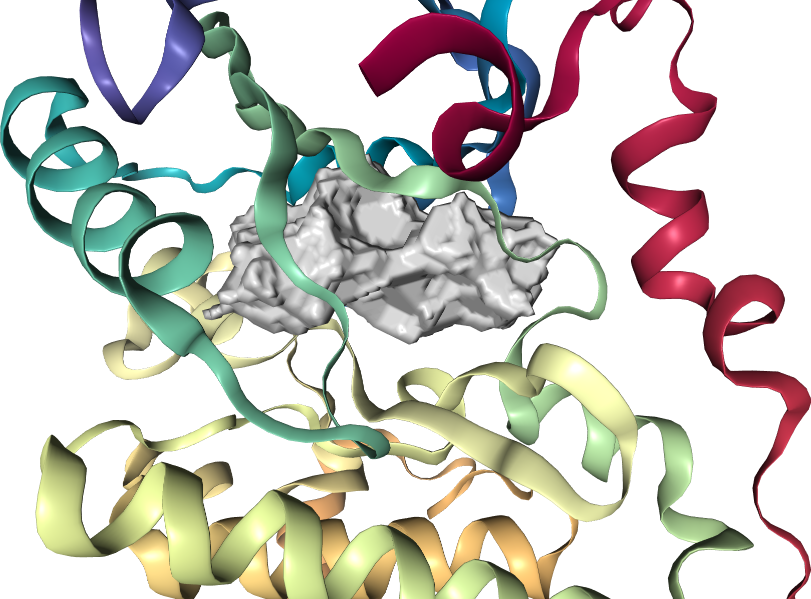

In [20]:
viewer._display_image()

The above rendered image shows the same content as when using the proteins.plus web server directly (see Figure 1). 

### Comparison between DoGSiteScorer and KLIFS pocket

#### Get DoGSiteScorer pocket residues
Since we want to compare the automatically predicted pocket with the manually assigned KLIFS pocket, we need to identify the pocket residues.

In [21]:
def get_pocket_residues(pocket_url):
    """
    Gets residue IDs and names of a specified pocket (via URL).

    Parameters
    ----------
    pocket_url : str
        URL of selected pocket file on the DoGSiteScorer web server.

    Returns
    -------
    pandas.DataFrame
        Table of residues names and IDs for the selected binding site.
    """

    # Retrieve PDB file content from URL
    result = requests.get(pocket_url)

    # Get content of PDB file
    pdb_residues = result.text

    # Load PDB format as DataFrame
    ppdb = PandasPdb()
    # TODO: Change _construct_df to read_pdb_from_lines once biopandas
    # cuts a new release (currently: 0.2.7), see https://github.com/rasbt/biopandas/pull/72
    pdb_df = ppdb._construct_df(pdb_residues.splitlines(True))["ATOM"]

    # Drop duplicates
    # PDB file contains per atom entries, we only need per residue info
    pdb_df.sort_values("residue_number", inplace=True)
    pdb_df.drop_duplicates(subset="residue_number", keep="first", inplace=True)

    return pdb_df[["residue_number", "residue_name"]]

We get the residues of selected pocket and show the top 5 residues.

In [22]:
dogsite_pocket_residues_df = get_pocket_residues(selected_pocket_residues_url)
dogsite_pocket_residues_df.head()
# NBVAL_CHECK_OUTPUT

,residue_number,residue_name
0,718,LEU
4,726,VAL
11,743,ALA
12,744,ILE
20,745,LYS


**Another pocket visualization**

We can also use the selected pocket residues to investigate our pocket in 3D.

In [23]:
# Show protein structure as cartoon
viewer = nglview.show_pdbid(pdb_id)
# Select pocket residues
selection = (
    f":{chain_id} and ({' or '.join(dogsite_pocket_residues_df['residue_number'].astype(str))})"
)
# Show pocket residues as stick
viewer.add_representation("ball+stick", selection=selection, aspectRatio=1.0)
# Show ligand as ball and stick
viewer.add_representation("ball+stick", selection=ligand_id.split("_")[0])
viewer.center()
viewer

NGLWidget()

In [24]:
viewer.render_image(trim=True, factor=2);

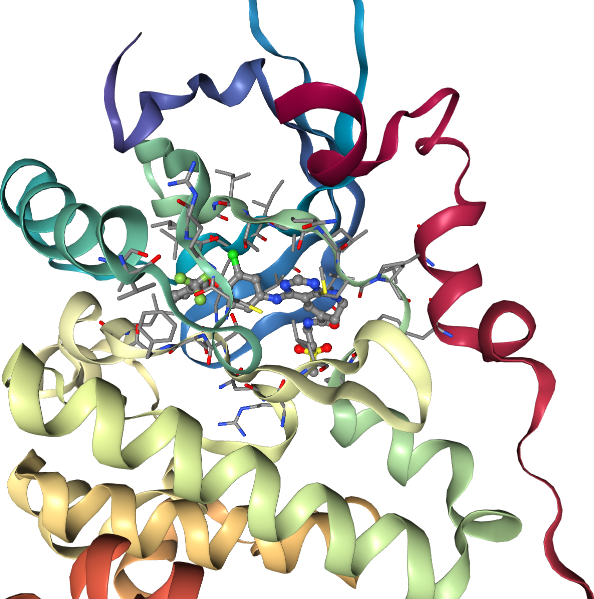

In [25]:
viewer._display_image()

#### Get KLIFS pocket residues

We are using the `opencadd.databases.klifs` module to extract the binding site residues (PDB residue numbering) as defined in the KLIFS database.

Please refer to __Talktorial T012__ for detailed information about KLIFS and the `opencadd.databases.klifs` module usage.

In [26]:
session = setup_remote()

In [27]:
# Get first structure KLIFS ID associated with PDB ID
structures = session.structures.by_structure_pdb_id(pdb_id)
structure_klifs_id = structures["structure.klifs_id"].iloc[0]

In [28]:
# Get the structure's pocket
klifs_pocket_df = session.pockets.by_structure_klifs_id(structure_klifs_id)
# Residue ID: Cast string to int
klifs_pocket_df = klifs_pocket_df.astype({"residue.id": int})
klifs_pocket_df.head()
# NBVAL_CHECK_OUTPUT

,residue.klifs_id,residue.id,residue.klifs_region_id,residue.klifs_region,residue.klifs_color
0,1,716,I.1,I,khaki
1,2,717,I.2,I,khaki
2,3,718,I.3,I,khaki
3,4,719,g.l.4,g.l,green
4,5,720,g.l.5,g.l,green


#### Overlap of pocket residues

In [29]:
# Get DoGSiteScorer pocket residues as list
dogsite_pocket_residues = dogsite_pocket_residues_df["residue_number"].to_list()
print(
    f"DoGSiteScorer pocket {best_pocket_id} with {len(dogsite_pocket_residues)} residues detected."
)
# Get KLIFS pocket residues as list
klifs_pocket_residues = klifs_pocket_df["residue.id"].to_list()
print(f"KLIFS pocket with {len(klifs_pocket_residues)} residues detected.")

DoGSiteScorer pocket P_0_0 with 29 residues detected.
KLIFS pocket with 85 residues detected.


In [30]:
overlap = set.intersection(set(dogsite_pocket_residues), set(klifs_pocket_residues))
print(f"Overlap between the two residue sets: {len(overlap)}.")
# NBVAL_CHECK_OUTPUT

Overlap between the two residue sets: 27.


Plot the overlap as Venn diagram.

Residue overlap between the two methods using P_0_0.


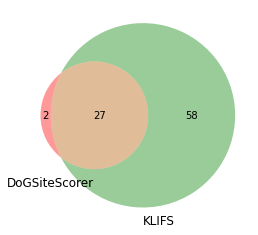

In [31]:
print(f"Residue overlap between the two methods using {best_pocket_id}.")
venn2(
    [set(dogsite_pocket_residues), set(klifs_pocket_residues)],
    set_labels=("DoGSiteScorer", "KLIFS"),
)
plt.show()

As we can see, the subpocket we choose from DoGSiteScorer is very precise. In fact, 27 out of the 29 residues do overlap with the KLIFS definition (85 residues).
Though, the KLIFS pocket covers a larger overall pocket area.
Out of interest, we can also do the same comparison using the pocket ``P_0`` (instead of subpocket ``P_0_0``) to see how that compares to KLIFS.

In [32]:
# Get info for largest DoGSiteScorer pocket P_0
new_pocket_id = "P_0"
dogsite_pocket_residues_df_p0 = get_pocket_residues(
    get_selected_pocket_location(job_location, new_pocket_id)
)
dogsite_pocket_residues_p0 = dogsite_pocket_residues_df_p0["residue_number"].to_list()
print(f"DoGSiteScorer pocket {new_pocket_id} with {len(dogsite_pocket_residues_p0)} detected.")
# NBVAL_CHECK_OUTPUT

DoGSiteScorer pocket P_0 with 62 detected.


Residue overlap between the two methods using P_0.


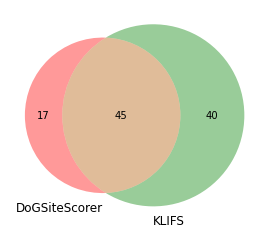

In [33]:
print(f"Residue overlap between the two methods using {new_pocket_id}.")
venn2(
    [set(dogsite_pocket_residues_p0), set(klifs_pocket_residues)],
    set_labels=("DoGSiteScorer", "KLIFS"),
)
plt.show()

## Discussion

We introduced the idea of binding site detection algorithms using DoGSiteScorer, which can be queried through the [proteins.plus](https://proteins.plus) server.
Besides investigating into the main (known) binding site, as exemplified above, one can use other predicted pockets to initiate drug design campaigns against a novel, e.g. allosteric or less explored, pocket.

Potential shortcomings: Such algorithms detect the pockets based on a given protein structure (x-ray). If another structure of the same protein is available, applying the algorithm to that structure might lead to (slightly) different pockets due to e.g. conformational changes induced by the bound ligand. Also differences between apo and holo structures do affect the predictions.

## Quiz

1. What techniques can be invoked to automatically detect pockets on the protein surface?
2. What are advantages and disadvantages of automatic binding site detection algorithms?
3. Try another protein EGFR kinase structure and check the overlap between the predicted residues.